# Hands on Machine Learning (ML) for Materials

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/AEM/blob/main/2_Hands_on_ML_for_Materials.ipynb)

In [1]:
pip install mp-api pandas

  Using cached pymatgen-2025.3.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 11.5 MB/s eta 0:00:00
Using cached pymatgen-2025.3.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.4/862.4 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from mp_api.client import MPRester
import pandas as pd

# Your Materials Project API key
API_KEY = ''

# Connect to Materials Project and retrieve elasticity data
with MPRester(API_KEY) as mpr:
    elasticity_docs = mpr.elasticity.search(fields=[
        "composition",
        "composition_reduced",
        "formula_pretty",
        "chemsys",
        "volume",
        "density",
        "density_atomic",
        "symmetry",
        "property_name",
        "material_id",
        "origins",
        "warnings",
        "structure",
        "elastic_tensor",
        "bulk_modulus",
        "shear_modulus",
        "sound_velocity",
        "thermal_conductivity",
        "young_modulus"
    ])




<ipython-input-2-5c777afa445e>:9: DeprecationWarning: Accessing elasticity data through MPRester.elasticity is deprecated. Please use MPRester.materials.elasticity instead.
  elasticity_docs = mpr.elasticity.search(fields=[
/usr/local/lib/python3.11/dist-packages/mp_api/client/core/client.py:519: UserWarning: Ignoring `fields` argument: All fields are always included when no query is provided.
  warnings.warn(


Retrieving ElasticityDoc documents:   0%|          | 0/13283 [00:00<?, ?it/s]

In [3]:
# Prepare data for DataFrame
data = []
for doc in elasticity_docs:
    data.append({
        'Material ID': doc.material_id,
        'Formula': doc.formula_pretty,
        'Composition': doc.composition,
        'Reduced Composition': doc.composition_reduced,
        'Chemical System': doc.chemsys,
        'Volume (Å³)': doc.volume,
        'Density (g/cm³)': doc.density,
        'Atomic Density (atoms/Å³)': doc.density_atomic,
        'Symmetry': doc.symmetry,
        'Property Name': doc.property_name,
        'Origins': doc.origins,
        'Warnings': doc.warnings,
        'Structure': doc.structure if doc.structure else None,
        'Elastic Tensor': doc.elastic_tensor.ieee_format if doc.elastic_tensor else None,
        'Bulk Modulus (GPa)': doc.bulk_modulus,
        'Shear Modulus (GPa)': doc.shear_modulus,
        'Sound Velocity (m/s)': doc.sound_velocity,
        'Thermal Conductivity (W/m·K)': doc.thermal_conductivity,
        'Young\'s Modulus (GPa)': doc.young_modulus
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV file
df.to_hdf('elasticity_full_properties.h5', key='df', mode='w')

print(f"Retrieved elasticity data for {len(df)} materials.")

<ipython-input-3-014ee813a00b>:30: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['Material ID', 'Formula', 'Composition', 'Reduced Composition',
       'Chemical System', 'Symmetry', 'Property Name', 'Origins', 'Warnings',
       'Structure', 'Elastic Tensor', 'Bulk Modulus (GPa)',
       'Shear Modulus (GPa)', 'Sound Velocity (m/s)',
       'Thermal Conductivity (W/m·K)', 'Young's Modulus (GPa)'],
      dtype='object')]

  df.to_hdf('elasticity_full_properties.h5', key='df', mode='w')


Retrieved elasticity data for 13283 materials.


In [4]:
df.head()

,Material ID,Formula,Composition,Reduced Composition,Chemical System,Volume (Å³),Density (g/cm³),Atomic Density (atoms/Å³),Symmetry,Property Name,Origins,Warnings,Structure,Elastic Tensor,Bulk Modulus (GPa),Shear Modulus (GPa),Sound Velocity (m/s),Thermal Conductivity (W/m·K),Young's Modulus (GPa)
0,mp-1120447,Si,(Si),(Si),Si,168.508435,2.214112,21.063554,crystal_system=<CrystalSystem.tri: 'Triclinic'...,elasticity,[],[],"[[ 0.91381979 -1.36229397 5.52185909] Si, [2....","((105.0, 30.0, 48.0, 1.0, -6.0, 0.0), (30.0, 1...",voigt=68.415 reuss=67.285 vrh=67.85,voigt=33.907 reuss=22.182 vrh=28.045,transverse=3559.027301017632 longitudinal=6894...,clarke=0.910113764225502 cahill=1.022770927536353,None
1,mp-644693,Si,(Si),(Si),Si,169.205562,2.204990,21.150695,crystal_system=<CrystalSystem.tri: 'Triclinic'...,elasticity,[],[Critical: Expect 24 total (primary plus deriv...,"[[3.13549135 3.04005186 0.97117936] Si, [-1.60...","((99.0, 40.0, 28.0, 11.0, 10.0, -21.0), (40.0,...",voigt=58.34 reuss=39.828 vrh=49.084,voigt=30.938 reuss=9.631 vrh=20.284,transverse=3033.0696374118265 longitudinal=587...,clarke=0.7734928323129421 cahill=0.86925436821...,None
2,mp-1008395,C,(C),(C),C,24.056228,3.316270,6.014057,crystal_system=<CrystalSystem.tet: 'Tetragonal...,elasticity,[],[],[[ 7.89203437e-01 7.89203437e-01 -6.06082288e...,"((1189.0, 61.0, 61.0, 0.0, 0.0, 0.0), (61.0, 9...",voigt=402.314 reuss=400.654 vrh=401.484,voigt=427.585 reuss=414.981 vrh=421.283,transverse=11271.117697901174 longitudinal=170...,clarke=6.102947222321187 cahill=6.663471552904121,None
3,mp-1010136,Cu,(Cu),(Cu),Cu,12.044674,8.760770,12.044674,crystal_system=<CrystalSystem.tet: 'Tetragonal...,elasticity,[],"[Elastic tensor has negative eigenvalue(s), in...",[[0. 0. 0.] Cu],"((162.0, 129.0, 129.0, -0.0, -0.0, -0.0), (129...",voigt=137.934 reuss=137.731 vrh=137.832,voigt=59.284 reuss=124.768 vrh=92.026,transverse=3241.0764829329987 longitudinal=545...,clarke=1.160573775552204 cahill=1.26452697803883,None
4,mp-1095534,C,(C),(C),C,127.646346,1.874953,10.637195,crystal_system=<CrystalSystem.tet: 'Tetragonal...,elasticity,[],[],"[[-2.70419504 2.70419504 1.41890146] C, [ 2....","((232.0, 13.0, 13.0, 0.0, 0.0, -0.0), (13.0, 5...",voigt=162.128 reuss=136.002 vrh=149.065,voigt=93.785 reuss=35.767 vrh=64.776,transverse=5877.841046253327 longitudinal=1120...,clarke=2.362870299971141 cahill=2.642806026072...,None


In [5]:
doc.elastic_tensor

ElasticTensorDoc(raw=((154.0180351540882, 60.52825879085076, 29.55858397631392, 1.168518677604808e-11, 1.282141549531887e-11, 1.089224816670719), (60.52825879085076, 154.0984675810202, 35.739058001845606, 1.2231771551622908e-11, 5.022288874330621e-11, -1.122213241507827), (29.55858397631392, 35.739058001845606, 124.5921854096058, -1.418875703659722e-13, 2.2619140391828912e-14, 0.9431070724329371), (1.168518677604808e-11, 1.2231771551622908e-11, -1.418875703659722e-13, 22.490045425349223, 0.001004187392095, -7.790504049945338e-15), (1.282141549531887e-11, 5.022288874330621e-11, 2.2619140391828912e-14, 0.001004187392095, 22.535310423077107, -2.56476809542618e-15), (1.089224816670719, -1.122213241507827, 0.9431070724329371, -7.790504049945338e-15, -2.56476809542618e-15, 38.69867422137121)), ieee_format=((150.0, 65.0, 33.0, 0.0, 0.0, 0.0), (65.0, 150.0, 33.0, -0.0, -0.0, 0.0), (33.0, 33.0, 125.0, 0.0, -0.0, 0.0), (-0.0, -0.0, 0.0, 23.0, 0.0, 0.0), (0.0, 0.0, -0.0, 0.0, 23.0, 0.0), (0.0, 0.

In [6]:
doc.elastic_tensor.ieee_format

((150.0, 65.0, 33.0, 0.0, 0.0, 0.0),
 (65.0, 150.0, 33.0, -0.0, -0.0, 0.0),
 (33.0, 33.0, 125.0, 0.0, -0.0, 0.0),
 (-0.0, -0.0, 0.0, 23.0, 0.0, 0.0),
 (0.0, 0.0, -0.0, 0.0, 23.0, 0.0),
 (0.0, 0.0, 0.0, 0.0, 0.0, 43.0))

In [2]:
!pip install torch torchvision pandas matplotlib numpy pymatgen dscribe scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

In [7]:
import pandas as pd
import numpy as np
from pymatgen.core import Structure
from scipy.stats import zscore
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pymatgen.core import Structure
from ase import Atoms
from dscribe.descriptors import SOAP

In [8]:
# Set these constants uniquely per student assignment
N_SAMPLES = 5000  # Number of samples to use
SEED = 42         # Random seed to ensure reproducibility

np.random.seed(SEED)
torch.manual_seed(SEED)


In [9]:
df_full = pd.read_hdf('elasticity_full_properties.h5', key='df')

# Drop missing data
df_full = df_full.dropna(subset=['Structure', 'Elastic Tensor'])

FileNotFoundError: File elasticity_full_properties.h5 does not exist

In [ ]:
# Extract targets
tensor_components = ['C11', 'C22', 'C33', 'C12', 'C13', 'C23']
tensor_indices = [(0,0), (1,1), (2,2), (0,1), (0,2), (1,2)]

for i, (r, c) in enumerate(tensor_indices):
    df_full[tensor_components[i]] = df_full['Elastic Tensor'].apply(lambda x: np.array(x)[r,c])



In [ ]:
# IQR-based outlier removal for each tensor component
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean.reset_index(drop=True)

In [ ]:
df_clean = remove_outliers_iqr(df_full, tensor_components)
print(f"Removed {len(df_full)-len(df_clean)} outliers. Remaining data: {len(df_clean)}")


In [ ]:
df_clean_shuffled = df_clean.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Select only first N_SAMPLES
df_final = df_clean_shuffled.iloc[:N_SAMPLES].reset_index(drop=True)
print(f"Final dataset size: {len(df_final)}")

In [ ]:
from pymatgen.core import Composition
from pymatgen.analysis.periodic_table import Element
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Count element frequencies in the training set
element_counts = {}

for s in df_final.iloc[train_idx]['Structure']:
    comp = Composition.from_dict(eval(s)['composition'])
    for el in comp:
        element_counts[el] = element_counts.get(el, 0) + comp[el]

# Normalize frequencies (optional)
total_atoms = sum(element_counts.values())
element_freq = {el: count / total_atoms for el, count in element_counts.items()}

# Create periodic table grid
ptable = np.full((10, 18), np.nan)
for el in element_freq:
    element = Element(el)
    row, group = element.row - 1, element.group - 1
    if 0 <= row < 10 and 0 <= group < 18:
        ptable[row, group] = element_freq[el]

# Plotting
plt.figure(figsize=(16, 6))
sns.heatmap(ptable, cmap='viridis', cbar_kws={'label': 'Relative Element Frequency'}, square=True,
            linewidths=0.5, linecolor='gray')

# Add element symbols to the plot
for el in element_freq:
    element = Element(el)
    row, group = element.row - 1, element.group - 1
    if 0 <= row < 10 and 0 <= group < 18:
        plt.text(group + 0.5, row + 0.5, el, ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.title('Element Frequency in Training Set (Periodic Table)')
plt.xticks([])
plt.yticks([])
plt.show()


In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pymatgen.core import Structure
from ase import Atoms
from dscribe.descriptors import SOAP


class ElasticSOAPDataset(Dataset):
    def __init__(self, dataframe, soap_params):
        self.df = dataframe
        self.soap = SOAP(**soap_params)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        structure = self.df.loc[idx, 'Structure']

        ase_structure = Atoms(
            symbols=[str(s.specie) for s in structure],
            positions=structure.cart_coords,
            cell=structure.lattice.matrix,
            pbc=True
        )

        feature = self.soap.create(ase_structure, n_jobs=1).flatten()

        target = self.df.loc[idx, ['C11', 'C22', 'C33', 'C12', 'C13', 'C23']].values.astype(float)

        return torch.tensor(feature, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)



In [67]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(df_final))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

species = list({str(el) for s in df_final['Structure'] for el in s.species})

soap_params = {
    'species': species,
    'periodic': True,
    'r_cut': 6.0,
    'n_max': 8,
    'l_max': 2,
    'average': 'inner'
}

train_dataset = ElasticSOAPDataset(df_final.iloc[train_idx].reset_index(drop=True), soap_params)
test_dataset = ElasticSOAPDataset(df_final.iloc[test_idx].reset_index(drop=True), soap_params)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [84]:
import torch.nn as nn

class ElasticSOAPNet(nn.Module):
    def __init__(self, input_dim, output_dim=6):
        super(ElasticSOAPNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Instantiate model with input dimension from one sample

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [86]:
sample_feature, _ = train_dataset[0]
model = ElasticSOAPNet(input_dim=sample_feature.shape[0]).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)


In [87]:
from tqdm import tqdm

epochs = 10
model.train()

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    for i, (features, targets) in enumerate(progress):
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / (i + 1)

        progress.set_postfix(batch_loss=f"{loss.item():.4f}", epoch_avg_loss=f"{avg_epoch_loss:.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Validation loss computation
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for val_features, val_targets in test_loader:
            val_features, val_targets = val_features.to(device), val_targets.to(device)
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_targets)
            val_epoch_loss += val_loss.item()

    val_epoch_loss /= len(test_loader)
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

    model.train()


Epoch 1/10: 100%|██████████| 500/500 [01:15<00:00,  6.62batch/s, batch_loss=791.2875, epoch_avg_loss=5516.0415]


Epoch [1/10] Train Loss: 5516.0415 | Val Loss: 2940.5404


Epoch 2/10: 100%|██████████| 500/500 [01:15<00:00,  6.64batch/s, batch_loss=1258.8187, epoch_avg_loss=3259.6491]


Epoch [2/10] Train Loss: 3259.6491 | Val Loss: 2609.0371


Epoch 3/10: 100%|██████████| 500/500 [01:15<00:00,  6.64batch/s, batch_loss=3417.4619, epoch_avg_loss=2848.7416]


Epoch [3/10] Train Loss: 2848.7416 | Val Loss: 2432.6506


Epoch 4/10: 100%|██████████| 500/500 [01:16<00:00,  6.53batch/s, batch_loss=1812.0364, epoch_avg_loss=2596.5561]


Epoch [4/10] Train Loss: 2596.5561 | Val Loss: 2647.9149


Epoch 5/10: 100%|██████████| 500/500 [01:16<00:00,  6.52batch/s, batch_loss=2706.4375, epoch_avg_loss=2377.9629]


Epoch [5/10] Train Loss: 2377.9629 | Val Loss: 2430.0094


Epoch 6/10: 100%|██████████| 500/500 [01:16<00:00,  6.51batch/s, batch_loss=6245.7461, epoch_avg_loss=2428.6601]


Epoch [6/10] Train Loss: 2428.6601 | Val Loss: 2230.6855


Epoch 7/10: 100%|██████████| 500/500 [01:16<00:00,  6.51batch/s, batch_loss=573.9331, epoch_avg_loss=2350.6484]


Epoch [7/10] Train Loss: 2350.6484 | Val Loss: 2285.8122


Epoch 8/10: 100%|██████████| 500/500 [01:16<00:00,  6.54batch/s, batch_loss=3148.3972, epoch_avg_loss=2184.2889]


Epoch [8/10] Train Loss: 2184.2889 | Val Loss: 2652.9121


Epoch 9/10: 100%|██████████| 500/500 [01:15<00:00,  6.58batch/s, batch_loss=877.7172, epoch_avg_loss=2171.8359]


Epoch [9/10] Train Loss: 2171.8359 | Val Loss: 2301.8879


Epoch 10/10: 100%|██████████| 500/500 [01:16<00:00,  6.54batch/s, batch_loss=1022.4392, epoch_avg_loss=2109.6075]


Epoch [10/10] Train Loss: 2109.6075 | Val Loss: 2323.1467


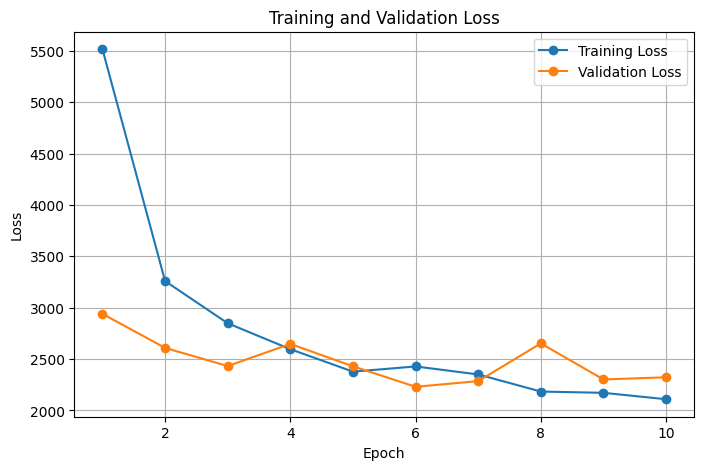

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def get_predictions(model, loader, device):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for features, targets in tqdm(loader, desc='Evaluating'):
            features = features.to(device)
            outputs = model(features).cpu().numpy()
            preds.append(outputs)
            actuals.append(targets.numpy())
    return np.vstack(actuals), np.vstack(preds)

# Predictions on Train and Test datasets
train_actuals, train_preds = get_predictions(model, train_loader, device)
test_actuals, test_preds = get_predictions(model, test_loader, device)


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 12.89it/s]


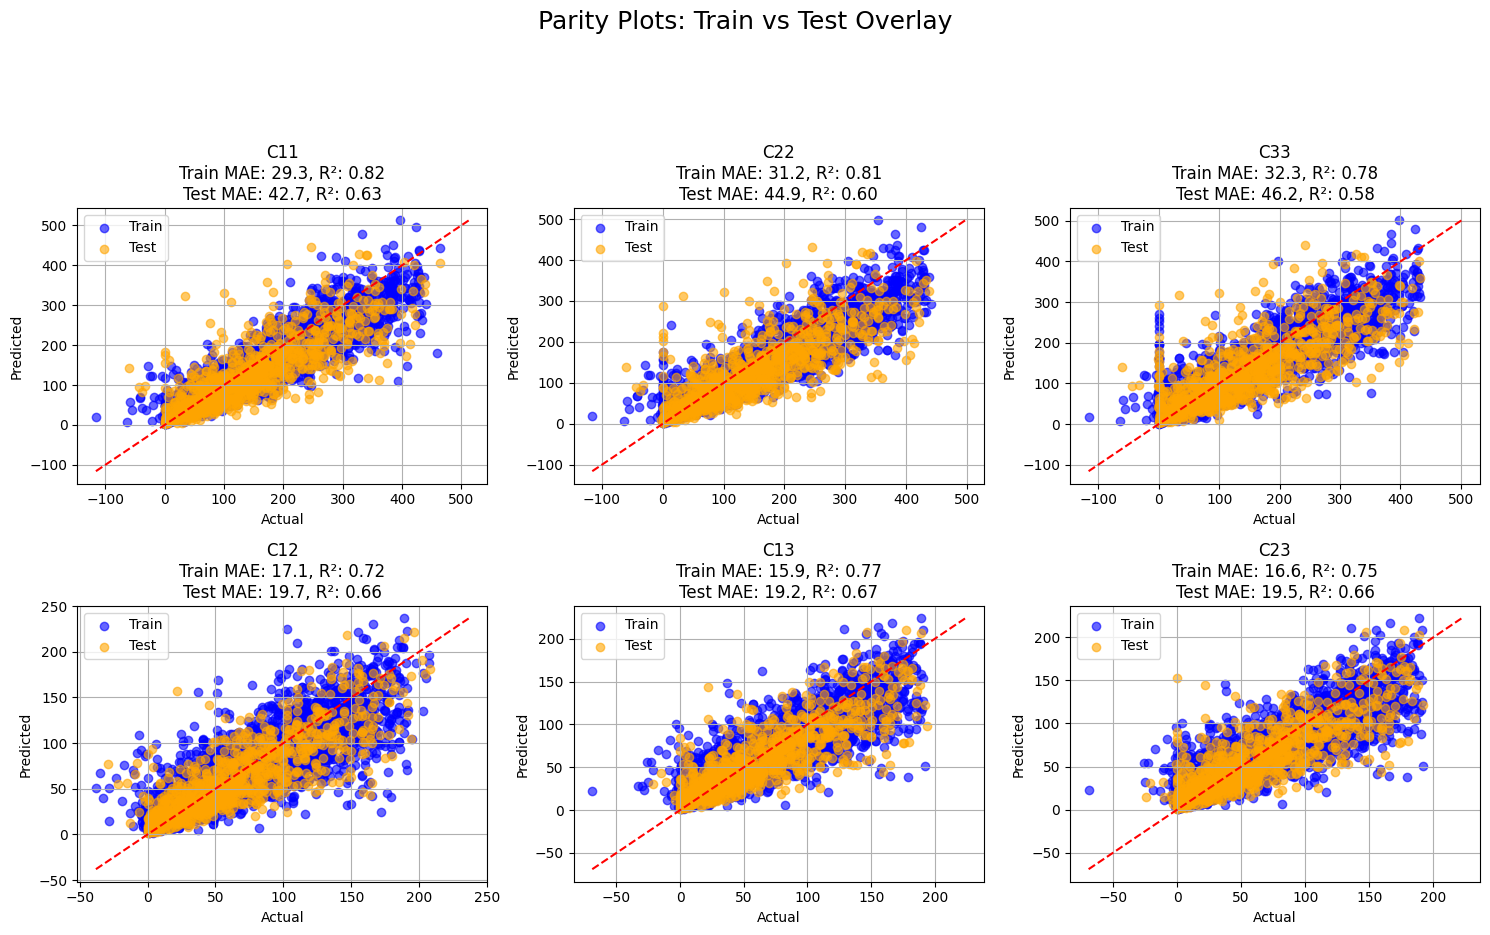

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

tensor_components = ['C11', 'C22', 'C33', 'C12', 'C13', 'C23']

fig, axes = plt.subplots(2 ,3, figsize=(15, 10))
fig.suptitle('Parity Plots: Train vs Test Overlay', fontsize=18)

for i, comp in enumerate(tensor_components):
    # Train metrics
    train_mae = mean_absolute_error(train_actuals[:, i], train_preds[:, i])
    train_r2 = r2_score(train_actuals[:, i], train_preds[:, i])

    # Test metrics
    test_mae = mean_absolute_error(test_actuals[:, i], test_preds[:, i])
    test_r2 = r2_score(test_actuals[:, i], test_preds[:, i])

    ax = axes.reshape(-1)[i]
    ax.scatter(train_actuals[:, i], train_preds[:, i], alpha=0.6, label='Train', color='blue')
    ax.scatter(test_actuals[:, i], test_preds[:, i], alpha=0.6, label='Test', color='orange')

    # Identity line
    all_vals = np.concatenate([train_actuals[:, i], train_preds[:, i], test_actuals[:, i], test_preds[:, i]])
    min_val, max_val = all_vals.min(), all_vals.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    ax.set_title(f'{comp}\nTrain MAE: {train_mae:.1f}, R²: {train_r2:.2f}\nTest MAE: {test_mae:.1f}, R²: {test_r2:.2f}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()


In [91]:
axes

array([[<Axes: title={'center': 'C11\nTrain MAE: 29.3, R²: 0.82\nTest MAE: 42.7, R²: 0.63'}, xlabel='Actual', ylabel='Predicted'>,
        <Axes: title={'center': 'C22\nTrain MAE: 31.2, R²: 0.81\nTest MAE: 44.9, R²: 0.60'}, xlabel='Actual', ylabel='Predicted'>,
        <Axes: title={'center': 'C33\nTrain MAE: 32.3, R²: 0.78\nTest MAE: 46.2, R²: 0.58'}, xlabel='Actual', ylabel='Predicted'>],
       [<Axes: title={'center': 'C12\nTrain MAE: 17.1, R²: 0.72\nTest MAE: 19.7, R²: 0.66'}, xlabel='Actual', ylabel='Predicted'>,
        <Axes: title={'center': 'C13\nTrain MAE: 15.9, R²: 0.77\nTest MAE: 19.2, R²: 0.67'}, xlabel='Actual', ylabel='Predicted'>,
        <Axes: title={'center': 'C23\nTrain MAE: 16.6, R²: 0.75\nTest MAE: 19.5, R²: 0.66'}, xlabel='Actual', ylabel='Predicted'>]],
      dtype=object)